In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set the styles to Seaborn
sns.set()
# Import the KMeans module so we can perform k-means clustering with sklearn
from sklearn.cluster import KMeans

**K-Means Nasıl Çalışır**

K-means algoritmasının çalışma mekanizmasına göre öncelikle her kümenin merkez noktasını veya ortalamasını temsil etmek üzere K adet nesne rastgele seçilir. Kalan diğer nesneler, kümelerin ortalama değerlerine olan uzaklıkları dikkate alınarak en benzer oldukları kümelere dahil edilir. Daha sonra, her bir kümenin ortalama değeri hesaplanarak yeni küme merkezleri belirlenir ve tekrar nesnelerin merkeze uzaklıkları incelenir. Herhangi bir değişim olmayıncaya kadar algoritma tekrarlamaya devam eder.

Algoritma temel olarak 4 aşamadan oluşur:

1. Küme merkezlerinin belirlenmesi
2. Merkez dışındaki verilerin mesafelerine göre kümelendirilmesi
3. Yapılan kümelendirmeye göre yeni merkezlerin belirlenmesi (veya eski merkezlerin yeni merkeze kaydırılması)
4. Kararlı hale (stable state) gelinene kadar 2. ve 3. adımların tekrarlanması.

Elbow metodu; noktaların her K değerine göre küme merkezine uzaklıklarının karesi toplamı hesaplanmaktadır. Bu değerlere göre her K değeri için grafik çizilmektedir. Grafik üzerinde toplamlar arasındaki farkın azalmaya başladığı dirsek noktası en uygun K değeri olarak belirlenmektedir. Dirsek yöntemi olarak da bilinir.

Öncelikle bir çok konuda olduğu gibi ideal küme sayısını neye göre seçeceğimizi belirleyecek bir metrik olmalıdır. Kümelemedeki temel mantığı hatırlayalım: Birbirine benzeyenler, yakın olanlar aynı kümede olsun birbirine benzemeyenlerle mümkün olduğunca uzak olsunlar. Bunu sağlayacak bir metrik var: Within Clusters Sum of Square (WCSS) Türkçesi şöyle: Kümeler içi kareler toplamı.

Korelasyon, olasılık kuramı ve istatistikte iki rassal değişken arasındaki doğrusal ilişkinin yönünü ve gücünü belirtir. Genel istatistiksel kullanımda korelasyon, bağımsızlık durumundan ne kadar uzaklaşıldığını gösterir.

Örneklem korelasyon katsayısı mümkün uçsal değerler olan -1 veya +1 olursa, çok iyi iki değişken arasında çok iyi bir doğrusal bağlantı bulunduğu kabul edilir.

# **K-Means Algoritması İle Baş Ağrısı Tanısı**

In [ ]:
dataset = pd.read_csv("/kaggle/input/migraine-classification/data.csv") 
#dataseti tanımladık

In [ ]:
dataset.shape
# kaç veriyle uğraşıyoruz bir bakalım

(400, 24)

In [ ]:
dataset.head()
#ilk 5 satırı yazdırdık

,Age,Duration,Frequency,Location,Character,Intensity,Nausea,Vomit,Phonophobia,Photophobia,...,Vertigo,Tinnitus,Hypoacusis,Diplopia,Defect,Ataxia,Conscience,Paresthesia,DPF,Type
0,30,1,5,1,1,2,1,0,1,1,...,0,0,0,0,0,0,0,0,0,Typical aura with migraine
1,50,3,5,1,1,3,1,1,1,1,...,1,0,0,0,0,0,0,0,0,Typical aura with migraine
2,53,2,1,1,1,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,Typical aura with migraine
3,45,3,5,1,1,3,1,0,1,1,...,1,0,0,0,0,0,0,0,0,Typical aura with migraine
4,53,1,1,1,1,2,1,0,1,1,...,0,0,0,0,0,0,0,0,1,Typical aura with migraine


In [ ]:
columns = dataset.columns[np.r_[0:1,1:2,2:3,6:7,7:8,10:11,14:15]]
fit_data = dataset[columns]
fit_data.head()

#inceleyeceğimiz 7 özellik seçtik 

,Age,Duration,Frequency,Nausea,Vomit,Visual,Vertigo
0,30,1,5,1,0,1,0
1,50,3,5,1,1,2,1
2,53,2,1,1,1,2,0
3,45,3,5,1,0,2,1
4,53,1,1,1,0,4,0


Verileri incelemek için standartlaştırma yapıyoruz.

Veriler 0-1 arasında  ölçeklenir.

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(fit_data)
features_normal = pd.DataFrame(features_normal)
features_normal.columns = fit_data.columns
features_normal.head()

,Age,Duration,Frequency,Nausea,Vomit,Visual,Vertigo
0,0.241935,0.0,0.571429,1.0,0.0,0.25,0.0
1,0.564516,1.0,0.571429,1.0,1.0,0.50,1.0
2,0.612903,0.5,0.000000,1.0,1.0,0.50,0.0
3,0.483871,1.0,0.571429,1.0,0.0,0.50,1.0
4,0.612903,0.0,0.000000,1.0,0.0,1.00,0.0


Korelasyonlara bakıp analiz edelim

In [ ]:
pd.DataFrame(features_normal).corr()

,Age,Duration,Frequency,Nausea,Vomit,Visual,Vertigo
Age,1.000000,-0.045263,0.073431,0.006542,-0.028650,0.047605,-0.026967
Duration,-0.045263,1.000000,0.149240,-0.144654,-0.046468,-0.058876,0.122716
Frequency,0.073431,0.149240,1.000000,0.037977,0.133929,-0.225082,-0.064355
Nausea,0.006542,-0.144654,0.037977,1.000000,0.077624,-0.012787,-0.161592
Vomit,-0.028650,-0.046468,0.133929,0.077624,1.000000,-0.150679,-0.082881
Visual,0.047605,-0.058876,-0.225082,-0.012787,-0.150679,1.000000,0.134596
Vertigo,-0.026967,0.122716,-0.064355,-0.161592,-0.082881,0.134596,1.000000


Korelasyon değerleri 1 ve -1 arası değişir.

Bunlara bir de grafikle bakalım

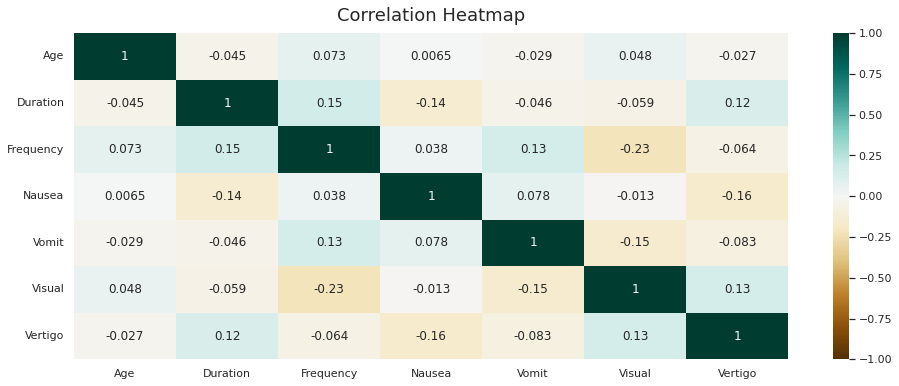

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(features_normal.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

Dirsek methodu ile kaç kümeye ayırmamız gerektiğini bulucaz.

In [ ]:
wcss = []
for i in range (1,10):
    kmeans= KMeans(i)
    kmeans.fit(features_normal)
    wcss.append(kmeans.inertia_)
    
wcss

[258.03804117933595,
 169.203274247457,
 132.86554967309564,
 107.16350673126973,
 90.80353272185943,
 80.41699868451873,
 74.81778071524641,
 68.90320019078825,
 62.08931558809725]

Verileri grafiğe dökelim

Text(0, 0.5, 'WCSS')

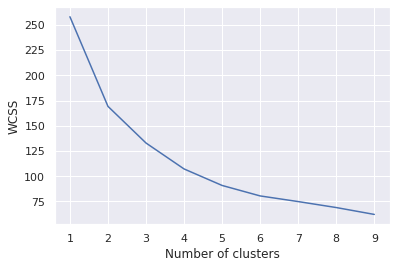

In [ ]:
plt.plot(range(1,10),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Grafiğin kıvrıldığı yere göre en iyi küme sayısını buluruz.

In [ ]:
kmeans_new = KMeans(2)
kmeans_new.fit(features_normal)
clusters = dataset.copy()
features_normal['cluster_pred'] = kmeans_new.fit_predict(features_normal)
clusters['cluster_pred'] = kmeans_new.fit_predict(features_normal)
#kümelenen değerleri hem standart hala getirdiğim features_normal'e hem de orijinal dataya cluster_pred ekledik

In [ ]:
features_normal.head()

,Age,Duration,Frequency,Nausea,Vomit,Visual,Vertigo,cluster_pred
0,0.241935,0.0,0.571429,1.0,0.0,0.25,0.0,0
1,0.564516,1.0,0.571429,1.0,1.0,0.50,1.0,1
2,0.612903,0.5,0.000000,1.0,1.0,0.50,0.0,1
3,0.483871,1.0,0.571429,1.0,0.0,0.50,1.0,0
4,0.612903,0.0,0.000000,1.0,0.0,1.00,0.0,0


In [ ]:
clusters.head()

,Age,Duration,Frequency,Location,Character,Intensity,Nausea,Vomit,Phonophobia,Photophobia,...,Tinnitus,Hypoacusis,Diplopia,Defect,Ataxia,Conscience,Paresthesia,DPF,Type,cluster_pred
0,30,1,5,1,1,2,1,0,1,1,...,0,0,0,0,0,0,0,0,Typical aura with migraine,0
1,50,3,5,1,1,3,1,1,1,1,...,0,0,0,0,0,0,0,0,Typical aura with migraine,1
2,53,2,1,1,1,2,1,1,1,1,...,0,0,0,0,0,0,0,0,Typical aura with migraine,1
3,45,3,5,1,1,3,1,0,1,1,...,0,0,0,0,0,0,0,0,Typical aura with migraine,0
4,53,1,1,1,1,2,1,0,1,1,...,0,0,0,0,0,0,0,1,Typical aura with migraine,0


cluster_pred sütunu ile hangi data nereye ait artık biliyoruz

Verileri yakılığa göre sınıflandıralım KNN ile ve yaptığımız kümelemenin doğruluğuna bakalım.

In [ ]:
# Bağımlı ve bağımsız değişkenlere göre ayıralım
x1=clusters[['Age','Duration','Frequency','Nausea','Vomit','Visual','Vertigo']]
y1=clusters['cluster_pred']
x1.head()

,Age,Duration,Frequency,Nausea,Vomit,Visual,Vertigo
0,30,1,5,1,0,1,0
1,50,3,5,1,1,2,1
2,53,2,1,1,1,2,0
3,45,3,5,1,0,2,1
4,53,1,1,1,0,4,0


In [ ]:
# K-Means Modelini oluşturalım
from sklearn.neighbors import KNeighborsClassifier
en_yakin=KNeighborsClassifier(n_neighbors=6)
en_yakin.fit(x1,y1)
KNeighborsClassifier(algorithm='auto',leaf_size=30,metric="minkowski",metric_params=None,n_jobs=1,n_neighbors=6,p=2,weights='uniform')

KNeighborsClassifier(n_jobs=1, n_neighbors=6)

En yakın modelle veri setini tahmin ettirelim.

In [ ]:
tahmin2=en_yakin.predict(x1)
tahmin2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,

kümelenmiş değerler ile buradan aldığımız değerleri karşılaştıralım

In [ ]:
np.array(y1)
df=pd.DataFrame(np.array(y1), columns=['y'])
df['Tahmin y']=tahmin2
df['aynımı']=df['y']==df['Tahmin y']
df
# y ler k means ile kümelenen / tahmin y ise en yakın komşu modelinden gelen

,y,Tahmin y,aynımı
0,0,0,True
1,1,0,False
2,1,0,False
3,0,0,True
4,0,0,True
...,...,...,...
395,1,1,True
396,0,0,True
397,0,0,True
398,0,0,True


In [ ]:
print(df.aynımı.value_counts('%'))

True     0.8325
False    0.1675
Name: aynımı, dtype: float64


%83 oranında doğruluk değeri var. 

Sonuç olarak bu modeli kullanırsak kümelemenin doğruluk oranı yükseldiğinden aynı zamanda migren tahmini yükselir. 

In [ ]:
df.to_excel("output.xlsx")

In [ ]:
# bir hastanın yeni verilerle hangi gruba dahil olduğuna bakalım
hasta_1 = np.array([[30,3,5,1,1,2,0]])
# age,duration,frequency,nausea,vomit,visual,vertigo
tahmin=en_yakin.predict(hasta_1)
tahmin_olasilik=en_yakin.predict_proba(hasta_1)
print('Tahmin:',tahmin)
print('Tahmin Olasılığı:', tahmin_olasilik)

Tahmin: [0]
Tahmin Olasılığı: [[0.66666667 0.33333333]]


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
